In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from tqdm.auto import tqdm 

In [2]:
import ast
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification
from tqdm.auto import tqdm
import random

# --- КОНФИГУРАЦИЯ ---
model_name = "iiiorg/piiranha-v1-detect-personal-information"
data_file = "/kaggle/input/hugedataset/more_pi_dataset (2).csv" 
tokenized_dataset_path = "./tokenized_log_dataset"

# --- ЗАГРУЗКА ---
print("--- Шаг 1: Загрузка токенизатора и датасета ---")
tokenizer = AutoTokenizer.from_pretrained(model_name)
full_dataset = load_dataset("csv", data_files=data_file, split="train")
print("Датасет загружен. Всего записей:", len(full_dataset))


# --- ФУНКЦИЯ ПРЕОБРАЗОВАНИЯ ---
def prepare_dataset(examples):
    examples["tokens"] = [ast.literal_eval(tok_list) for tok_list in examples["mbert_tokens"]]
    examples["ner_labels"] = [ast.literal_eval(label_list) for label_list in examples["mbert_token_classes"]]
    return examples

print("\n--- Шаг 2: Преобразование строковых колонок в списки ---")
columns_to_remove = [col for col in full_dataset.column_names if col not in ['mbert_tokens', 'mbert_token_classes']]
prepared_dataset = full_dataset.map(
    prepare_dataset,
    batched=True,
    num_proc=2,
    remove_columns=columns_to_remove,
    desc="Парсинг токенов и меток"
)
print("Преобразование завершено.")


# --- ИЗМЕНЕНИЕ: НОВЫЙ ШАГ БАЛАНСИРОВКИ ---
print("\n--- Шаг 2.5: Балансировка датасета (Undersampling) ---")

# Функция для проверки, есть ли в примере хоть одна PII метка
def has_pii(example):
    # set(example['ner_labels']) - {'O'} вернет True, если есть что-то кроме 'O'
    return bool(set(example['ner_labels']) - {'O'})

# Разделяем датасет на две части
pii_dataset = prepared_dataset.filter(has_pii, num_proc=2)
no_pii_dataset = prepared_dataset.filter(lambda x: not has_pii(x), num_proc=2)

print(f"Найдено {len(pii_dataset)} записей с PII.")
print(f"Найдено {len(no_pii_dataset)} записей без PII (только 'O').")

# Определяем, сколько "пустых" записей мы хотим оставить.
# Сделаем их количество равным количеству записей с PII (соотношение 1:1)
num_pii_samples = len(pii_dataset)

# Перемешиваем "пустые" записи и выбираем нужное количество
# seed=42 делает выбор случайным, но воспроизводимым
if len(no_pii_dataset) > num_pii_samples:
    print(f"Уменьшаю количество записей без PII с {len(no_pii_dataset)} до {num_pii_samples}.")
    no_pii_dataset_balanced = no_pii_dataset.shuffle(seed=42).select(range(num_pii_samples))
else:
    print("Количество записей без PII уже меньше или равно количеству записей с PII. Undersampling не требуется.")
    no_pii_dataset_balanced = no_pii_dataset

# Объединяем два датасета обратно в один, теперь сбалансированный
balanced_dataset = concatenate_datasets([pii_dataset, no_pii_dataset_balanced])
# Перемешиваем финальный датасет, чтобы PII и не-PII примеры шли вперемешку
balanced_dataset = balanced_dataset.shuffle(seed=42)

print(f"Размер нового сбалансированного датасета: {len(balanced_dataset)} записей.")


# --- Получение меток из модели ---
model_config = AutoModelForTokenClassification.from_pretrained(model_name).config
id2label = {int(k): v for k, v in model_config.id2label.items()}
label2id = {v: k for k, v in id2label.items()}
print("\nСловарь меток (label2id) из модели:", label2id)


# --- ФУНКЦИЯ ТОКЕНИЗАЦИИ (остается без изменений) ---
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
    )
    all_labels = []
    for i, ner_tags in enumerate(examples["ner_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                tag = ner_tags[word_idx]
                label_ids.append(label2id.get(tag, label2id["O"]))
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

# --- ОБРАБОТКА И СОХРАНЕНИЕ ---
print("\n--- Шаг 3: Начинаю токенизацию сбалансированных данных ---")
# Применяем токенизацию к нашему новому `balanced_dataset`
tokenized_datasets = balanced_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    num_proc=2,
    remove_columns=balanced_dataset.column_names,
    desc="Токенизация логов"
)
print("Токенизация завершена.")


print(f"\n--- Шаг 4: Сохраняю обработанный датасет в '{tokenized_dataset_path}' ---")
tokenized_datasets.save_to_disk(tokenized_dataset_path)
print("Подготовка данных успешно завершена!")

--- Шаг 1: Загрузка токенизатора и датасета ---
Датасет загружен. Всего записей: 100

--- Шаг 2: Преобразование строковых колонок в списки ---
Преобразование завершено.

--- Шаг 2.5: Балансировка датасета (Undersampling) ---
Найдено 100 записей с PII.
Найдено 0 записей без PII (только 'O').
Количество записей без PII уже меньше или равно количеству записей с PII. Undersampling не требуется.
Размер нового сбалансированного датасета: 100 записей.


2025-07-22 13:50:26.605746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753192226.629801     612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753192226.637108     612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Словарь меток (label2id) из модели: {'I-ACCOUNTNUM': 0, 'I-BUILDINGNUM': 1, 'I-CITY': 2, 'I-CREDITCARDNUMBER': 3, 'I-DATEOFBIRTH': 4, 'I-DRIVERLICENSENUM': 5, 'I-EMAIL': 6, 'I-GIVENNAME': 7, 'I-IDCARDNUM': 8, 'I-PASSWORD': 9, 'I-SOCIALNUM': 10, 'I-STREET': 11, 'I-SURNAME': 12, 'I-TAXNUM': 13, 'I-TELEPHONENUM': 14, 'I-USERNAME': 15, 'I-ZIPCODE': 16, 'O': 17}

--- Шаг 3: Начинаю токенизацию сбалансированных данных ---
Токенизация завершена.

--- Шаг 4: Сохраняю обработанный датасет в './tokenized_log_dataset' ---


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Подготовка данных успешно завершена!


In [3]:
!pip install seqeval
!pip install evaluate

In [4]:
# import transformers
# print(transformers.__version__)

In [5]:
# !pip install --upgrade --force-reinstall "numpy<2" "datasets" "transformers" "torch" "evaluate" "seqeval" "scikit-learn" "tqdm"

In [8]:
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    pipeline
)
import evaluate
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from transformers import EarlyStoppingCallback


# --- ИЗМЕНЕНИЕ 1: Добавляем импорты для графиков ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- КОНФИГУРАЦИЯ ---
model_name = "iiiorg/piiranha-v1-detect-personal-information"
tokenized_dataset_path = "./tokenized_log_dataset"
output_dir = "piiranha-finetuned-logs"
final_model_path = f"{output_dir}-final"

# --- ЗАГРУЗКА ---
print("Загружаю подготовленный датасет...")
tokenized_datasets_from_disk = load_from_disk(tokenized_dataset_path)
dataset_dict = tokenized_datasets_from_disk.train_test_split(test_size=0.2, seed=42) # Увеличим тест. выборку для более стабильной оценки

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# --- МЕТРИКИ ---
seqeval = evaluate.load("seqeval")
label_list = list(model.config.id2label.values())

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    per_class_results = {}
    for key, value in results.items():
        if isinstance(value, dict) and 'f1-score' in value:
             per_class_results[f"eval_{key}_f1"] = value['f1-score']
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
        **per_class_results
    }

# --- ИЗМЕНЕНИЕ 2: Оптимизируем настройки обучения ---
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-5,  # Немного увеличим для ускорения сходимости
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15, # Оставляем 15 эпох
    weight_decay=0.01,
    
    # Стратегии логирования, оценки и сохранения
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    
    # Ключевые параметры для управления памятью и выбором модели
    load_best_model_at_end=True,      # Загрузить лучшую модель в конце обучения
    metric_for_best_model="f1",       # Считать лучшей по общей F1-мере
    greater_is_better=True,           # Чем больше F1, тем лучше
    save_total_limit=1,               # Хранить ТОЛЬКО 1 лучший чекпоинт
    
    report_to="none", # Отключаем интеграции вроде wandb
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Остановить, если f1 не улучшается 3 эпохи подряд
    early_stopping_threshold=0.001, # Улучшением считается рост f1 хотя бы на 0.001
)

# --- ОБУЧЕНИЕ ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

print("Начинаю дообучение модели...")
train_result = trainer.train()

# --- СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ ---
trainer.save_model(final_model_path)
print(f"\nОбучение завершено. Лучшая модель сохранена в '{final_model_path}'")
print("Информация о тренировке:", train_result)

# --- ФУНКЦИЯ ДЛЯ ПРОСМОТРА ПРЕДСКАЗАНИЙ (остается без изменений) ---
def show_predictions(model_path, num_examples=5):
    print("\n--- Точный анализ предсказаний (без pipeline) ---")
    # Загружаем лучшую модель для анализа
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    test_set = dataset_dict["test"]

    for i in range(num_examples):
        if i >= len(test_set): break
        
        example = test_set[i]
        input_ids = torch.tensor(example['input_ids']).unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            logits = model(input_ids).logits
        
        predictions = torch.argmax(logits, dim=2).squeeze().tolist()
        
        tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
        true_labels = [label_list[l] if l != -100 else "PAD" for l in example['labels']]
        pred_labels = [label_list[p] for p in predictions]
        
        df = pd.DataFrame({
            'Токен': tokens, 
            'Реальная метка': true_labels, 
            'Предсказание модели': pred_labels
        })
        
        df_filtered = df[(df['Реальная метка'] != 'PAD') & (~df['Токен'].isin(['[CLS]', '[SEP]', '[PAD]']))]
        
        print(f"\n--- Пример #{i+1} ---")
        
        mismatches = df_filtered[df_filtered['Реальная метка'] != df_filtered['Предсказание модели']]
        real_pii = df_filtered[df_filtered['Реальная метка'] != 'O']
        
        display_df = pd.concat([real_pii, mismatches]).drop_duplicates().sort_index()

        if display_df.empty:
            print("Расхождений не найдено, и в примере нет PII.")
        else:
            print(display_df.to_string())

# Запускаем анализ предсказаний на лучшей сохраненной модели
show_predictions(final_model_path, num_examples=5)

Загружаю подготовленный датасет...


/tmp/ipykernel_612/3053669302.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Начинаю дообучение модели...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 


--- Построение графиков обучения ---


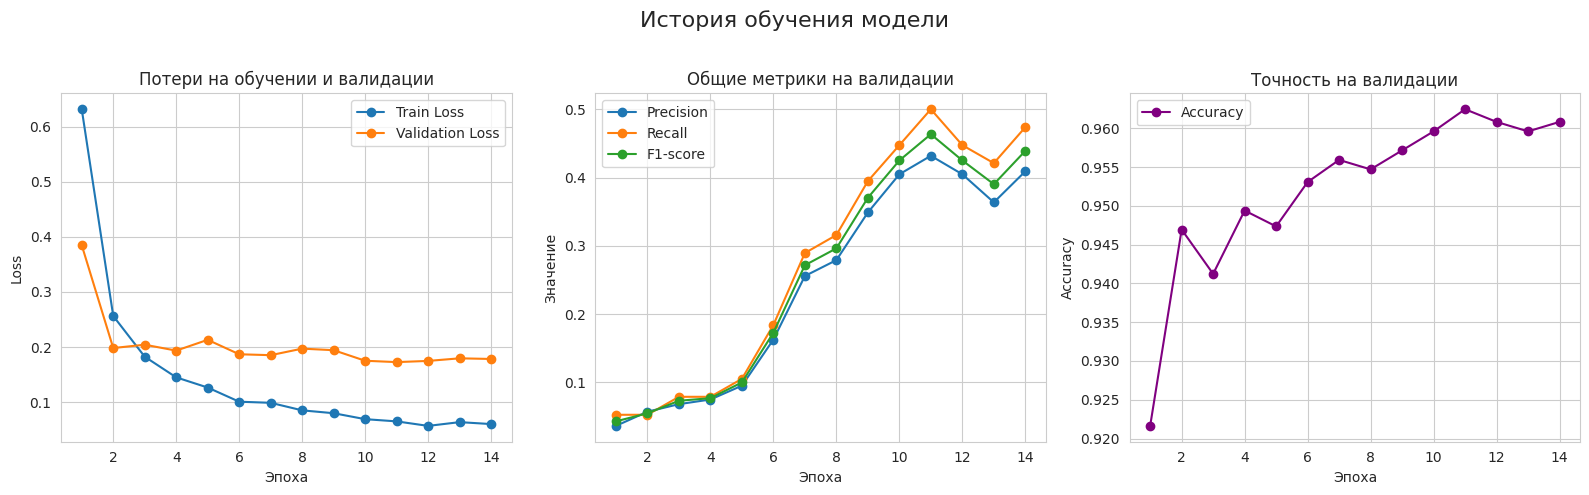

In [7]:
# --- ИЗМЕНЕНИЕ 3: ФУНКЦИЯ ДЛЯ ПОСТРОЕНИЯ ГРАФИКОВ ---
def plot_training_history(log_history):
    print("\n--- Построение графиков обучения ---")
    
    # Преобразуем историю в DataFrame
    logs = [log for log in log_history if 'loss' in log or 'eval_loss' in log]
    df = pd.DataFrame(logs)

    # Разделяем на train и eval
    train_df = df[df['loss'].notna()].reset_index(drop=True)
    eval_df = df[df['eval_loss'].notna()].reset_index(drop=True)

    # Настраиваем стиль графиков
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('История обучения модели', fontsize=16)

    # 1. График потерь (Loss)
    axs[0].plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
    axs[0].plot(eval_df['epoch'], eval_df['eval_loss'], label='Validation Loss', marker='o')
    axs[0].set_title('Потери на обучении и валидации')
    axs[0].set_xlabel('Эпоха')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # 2. График основных метрик (Precision, Recall, F1)
    axs[1].plot(eval_df['epoch'], eval_df['eval_precision'], label='Precision', marker='o')
    axs[1].plot(eval_df['epoch'], eval_df['eval_recall'], label='Recall', marker='o')
    axs[1].plot(eval_df['epoch'], eval_df['eval_f1'], label='F1-score', marker='o')
    axs[1].set_title('Общие метрики на валидации')
    axs[1].set_xlabel('Эпоха')
    axs[1].set_ylabel('Значение')
    axs[1].legend()

    # 3. График точности (Accuracy)
    axs[2].plot(eval_df['epoch'], eval_df['eval_accuracy'], label='Accuracy', marker='o', color='purple')
    axs[2].set_title('Точность на валидации')
    axs[2].set_xlabel('Эпоха')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Запускаем построение графиков
plot_training_history(trainer.state.log_history)